<a href="https://colab.research.google.com/github/SufyanKhanDilazak/Tool-Calling-Agent/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# History Searcher
i created this langgraph worflow for searching history by calling wikipedia tool

In [93]:
!pip install -q -U langgraph langsmith langchain langchain_community tavily-python

In [94]:
from typing_extensions import Annotated
from typing_extensions import TypedDict

import os
os.environ["TAVILY_API_KEY"] = "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"

from langchain_community.tools.tavily_search import TavilySearchResults


search = TavilySearchResults(
    max_results=3,
)

In [96]:
search.invoke("who was hitler")

[{'url': 'https://aboutholocaust.org/en/facts/who-was-adolf-hitler',
  'content': 'Who was Adolf Hitler? Who was Adolf Hitler? Adolf Hitler and Heinrich Himmler review SS troops during a Reichsparteitag (Reich Party Day) parade in Nuremberg (1938 September 05 – 1938 September 12). He became the leader of the German right-wing extremist National Socialist German Workers Party (known as the\xa0Nazi Party) in the early 1920s. A charismatic speaker, Hitler espoused radical nationalism and virulently anti-Semitic views, based largely on the false concept that Jews were responsible for Germany’s defeat in World War I, and that Germany’s greatness would be restored by the elimination of Jews and other inferior races as well as political opponents of Nazism and other undesirable elements from society.'},
 {'url': 'https://www.britannica.com/biography/Adolf-Hitler',
  'content': 'Also notable were Hermann Göring, who was a leader of the Nazi Party and one of the primary architects of the Nazi p

In [97]:
Tools = [search]

In [98]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [99]:
from langgraph.graph import StateGraph,START,END

In [ ]:
graph_builder= StateGraph(State)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY
)

response = llm.invoke

In [100]:
llm_with_tools=llm.bind_tools(tools=Tools)

In [101]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [102]:
from langgraph.prebuilt import ToolNode,tools_condition

In [103]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=Tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")
graph=graph_builder.compile()

ValueError: Node `chatbot` already present.

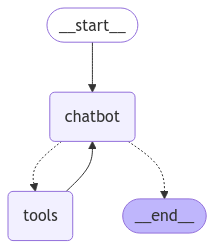

In [104]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [107]:
user_input="what is 5+5"
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

In [108]:
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

what is 5+5
================================== Ai Message ==================================
